# 双节倒立摆 Acrobot-v1

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
from scipy.special import xlogy
import pandas as pd
import gym
import tensorflow as tf
from tensorflow import keras
try: # tf2
    tf.random.set_seed(0)
    from tensorflow.keras.initializers import GlorotUniform
except: # tf1
    tf.random.set_random_seed(0)
    from tensorflow import glorot_uniform_initializer as GlorotUniform
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)

[0]

### 用简单的执行者评论家算法寻找最优策略

In [3]:
class ActorCriticAgent:
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1.

        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                loss=keras.losses.categorical_crossentropy,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=1,
                **critic_kwargs)
    
    def build_network(self, hidden_sizes, output_size,
                activation=tf.nn.relu, output_activation=None,
                loss=keras.losses.mse, learning_rate=0.01):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation,
                    kernel_initializer=GlorotUniform(seed=0)))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation,
                kernel_initializer=GlorotUniform(seed=0)))
        optimizer = keras.optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
      
    def decide(self, observation):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action
        
    def learn(self, observation, action, reward, next_observation, done):
        x = observation[np.newaxis]
        u = reward + self.gamma * \
                self.critic_net.predict(next_observation[np.newaxis])
        td_error = u - self.critic_net.predict(x)
        y = self.discount * td_error * \
                np.eye(self.action_n)[np.newaxis, action]
        self.actor_net.fit(x, y, verbose=0)
        self.critic_net.fit(x, u, verbose=0)
        
        if done:
            self.discount = 1.
        else:
            self.discount *= self.gamma

In [4]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done)
        if done:
            break
        observation = next_observation
    return episode_reward

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
平均回合奖励 = -50000.0 / 100 = -500.0


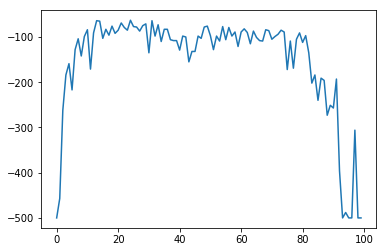

In [5]:
actor_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.001}
critic_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.001}
agent = ActorCriticAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent, train=False) \
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 邻近策略优化

In [6]:
class PPOReplayer:
    def __init__(self):
        self.memory = pd.DataFrame()
    
    def store(self, df):
        self.memory = pd.concat([self.memory, df], ignore_index=True)
        
    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field \
                in self.memory.columns)

class PPOAgent(ActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, clip_ratio=0.1,
            gamma=0.99, lambd=0.99, min_trajectory_length=1000,
            batches=1, batch_size=64):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.lambd = lambd
        self.min_trajectory_length = min_trajectory_length
        self.batches = batches
        self.batch_size = batch_size
        
        self.trajectory = []
        self.replayer = PPOReplayer()
        
        def ppo_loss(y_true, y_pred): # 损失函数
            # 真实值 y_true : (2*action_n,) 旧策略的策略概率 + 优势函数
            # 预测值 y_pred : (action,) 神经网络输出的策略概率 """
            p = y_pred
            p_old = y_true[:, :self.action_n]
            advantage = y_true[:, self.action_n:]
            surrogate_advantage = (p / p_old) * advantage
            clip_times_advantage = clip_ratio * advantage
            max_surrogate_advantage = advantage + tf.where(advantage > 0.,
                    clip_times_advantage, -clip_times_advantage)
            clipped_surrogate_advantage = tf.minimum(surrogate_advantage,
                    max_surrogate_advantage)
            return -tf.reduce_mean(clipped_surrogate_advantage, axis=-1)
        
        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax, loss=ppo_loss,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=1,
                **critic_kwargs)
        
    def learn(self, observation, action, reward, done):
        self.trajectory.append((observation, action, reward))
        
        if done:
            df = pd.DataFrame(self.trajectory, columns=['observation',
                    'action', 'reward'])
            observations = np.stack(df['observation'])
            df['v'] = self.critic_net.predict(observations)
            pis = self.actor_net.predict(observations)
            df['pi'] = [a.flatten() for a in np.split(pis, pis.shape[0])]
            
            df['next_v'] = df['v'].shift(-1).fillna(0.)
            df['u'] = df['reward'] + self.gamma * df['next_v']
            df['delta'] = df['u'] - df['v']
            df['return'] = df['reward']
            df['advantage'] = df['delta']
            for i in df.index[-2::-1]:
                df.loc[i, 'return'] += self.gamma * df.loc[i + 1, 'return']
                df.loc[i, 'advantage'] += self.gamma * self.lambd * \
                        df.loc[i + 1, 'advantage']
            fields = ['observation', 'action', 'pi', 'advantage', 'return']
            self.replayer.store(df[fields])
            self.trajectory = []
            
            if len(self.replayer.memory) > self.min_trajectory_length:
                for batch in range(self.batches):
                    observations, actions, pis, advantages, returns = \
                            self.replayer.sample(size=self.batch_size)
                    ext_advantages = np.zeros_like(pis)
                    ext_advantages[range(self.batch_size), actions] = \
                            advantages
                    actor_targets = np.hstack([pis, ext_advantages])
                    self.actor_net.fit(observations, actor_targets, verbose=0)
                    self.critic_net.fit(observations, returns, verbose=0)
                    
                self.replayer = PPOReplayer()

In [7]:
def play_montecarlo(env, agent, render=False, train=False):
    observation = env.reset()
    episode_reward = 0.
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, done)
        if done:
            break
        observation = next_observation
    return episode_reward

平均回合奖励 = -9361.0 / 100 = -93.61


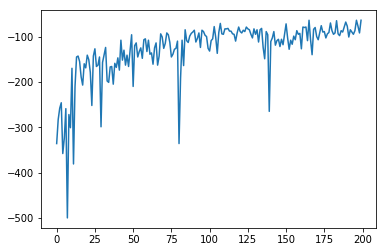

In [8]:
actor_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.003}
critic_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.005}
agent = PPOAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs, batches=80)

# 训练
episodes = 200
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_montecarlo(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_montecarlo(env, agent, train=False) 
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 异策算法

In [9]:
class OffPACAgent(ActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1.
        self.critic_learning_rate = critic_kwargs['learning_rate']
        
        def dot(y_true, y_pred):
            return -tf.reduce_sum(y_true * y_pred, axis=-1)
        
        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax, loss=dot, **actor_kwargs)
        self.critic_net = self.build_network(output_size=1,
                **critic_kwargs)
        
    def learn(self, observation, action, behavior, reward,
            next_observation, done):
        x = observation[np.newaxis, :]
        q = self.critic_net.predict(x)
        pi = self.actor_net.predict(x)
        rho = pi[0, action] / behavior
        y = self.discount * rho * np.eye(self.action_n)[np.newaxis, action]
        u = reward + self.gamma * \
                self.critic_net.predict(next_observation[np.newaxis, :])
        
        self.actor_net.fit(x, y, verbose=0)
        
        optimizer = keras.optimizers.SGD(rho * self.critic_learning_rate)
        self.critic_net.compile(optimizer=optimizer, loss=keras.losses.mse)
                # 部分Tensorflow版本的keras在重新编译模型时会内存泄漏
        self.critic_net.fit(x, u, verbose=0)
        
        if done:
            self.discount = 1.
        else:
            self.discount *= self.gamma

In [10]:
class RandomAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        
    def decide(self, observation):
        action = np.random.choice(self.action_n)
        behavior = 1. / self.action_n
        return action, behavior

平均回合奖励 = -27871.0 / 100 = -278.71


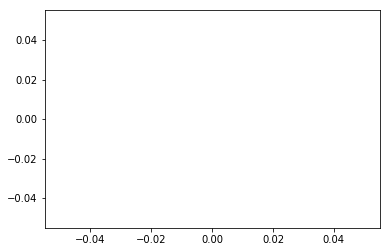

In [11]:
actor_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.001}
critic_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu, 
        'learning_rate' : 0.001}
agent = OffPACAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)
behavior_agent = RandomAgent(env)

# 训练
episodes = 0 # 由于keras.Model在recompile时内存泄漏，所以无法训练
episode_rewards = []
for episode in range(episodes):
    observation = env.reset()
    episode_reward = 0.
    while True:
        action, behavior = behavior_agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        agent.learn(observation, action, behavior, reward,
                next_observation, done)
        if done:
            break
        observation = next_observation
    
    # 跟踪监控
    episode_reward = play_qlearning(env, agent, train=False)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent, train=False) \
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 柔性执行者/评论者算法

In [12]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['observation', 'action', 'reward',
                'next_observation', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity
    
    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)
        
    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in \
                self.memory.columns)

In [13]:
class SACAgent:
    def __init__(self, env, actor_kwargs, critic_kwargs,
            replayer_capacity=10000, gamma=0.99, alpha=0.2,
            batches=1, batch_size=64, net_learning_rate=0.005):
        observation_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.alpha = alpha
        self.net_learning_rate = net_learning_rate
        self.batches = batches
        self.batch_size = batch_size
        
        self.replayer = DQNReplayer(replayer_capacity)
        
        def sac_loss(y_true, y_pred):
            """ y_true : Q (*, action_n), y_pred : pi (*, action_n) """
            qs = alpha * tf.math.xlogy(y_pred, y_pred) - y_pred * y_true
            return tf.reduce_sum(qs, axis=-1)
        
        self.actor_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, output_activation=tf.nn.softmax,
                loss=sac_loss, **actor_kwargs)
        self.q0_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, **critic_kwargs)
        self.q1_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, **critic_kwargs)
        self.v_evaluate_net = self.build_network(
                input_size=observation_dim, output_size=1, **critic_kwargs)
        self.v_target_net = self.build_network(
                input_size=observation_dim, output_size=1, **critic_kwargs)
        
        self.update_target_net(self.v_target_net, self.v_evaluate_net)
        
    def build_network(self, input_size, hidden_sizes, output_size,
            activation=tf.nn.relu, output_activation=None,
            loss=keras.losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for layer, hidden_size in enumerate(hidden_sizes):
            kwargs = {'input_shape' : (input_size,)} if layer == 0 else {}
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation,
                    kernel_initializer=GlorotUniform(seed=0), **kwargs))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation,
                kernel_initializer=GlorotUniform(seed=0)))
        optimizer = keras.optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
        
    def update_target_net(self, target_net, evaluate_net,
            learning_rate=1.):
        target_weights = target_net.get_weights()
        evaluate_weights = evaluate_net.get_weights()
        average_weights = [(1. - learning_rate) * t + learning_rate * e
                    for t, e in zip(target_weights, evaluate_weights)]
        target_net.set_weights(average_weights)
        
    def decide(self, observation):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action
    
    def learn(self, observation, action, reward, next_observation, done):
        self.replayer.store(observation, action, reward, next_observation,
                done)
        
        if done:
            for batch in range(self.batches):
                observations, actions, rewards, next_observations, \
                        dones = self.replayer.sample(self.batch_size)
                pis = self.actor_net.predict(observations)
                q0s = self.q0_net.predict(observations)
                q1s = self.q1_net.predict(observations)
                
                self.actor_net.fit(observations, q0s, verbose=0)
                
                q01s = np.minimum(q0s, q1s)
                entropic_q01s = pis * q01s - self.alpha * xlogy(pis, pis)
                v_targets = entropic_q01s.sum(axis=-1)
                self.v_evaluate_net.fit(observations, v_targets, verbose=0)
                
                next_vs = self.v_target_net.predict(next_observations)
                q_targets = rewards + \
                        self.gamma * (1. - dones) * next_vs[:, 0]
                q0s[range(self.batch_size), actions] = q_targets
                q1s[range(self.batch_size), actions] = q_targets
                self.q0_net.fit(observations, q0s, verbose=0)
                self.q1_net.fit(observations, q1s, verbose=0)
                
                self.update_target_net(self.v_target_net,
                        self.v_evaluate_net, self.net_learning_rate)

平均回合奖励 = -21930.0 / 100 = -219.3


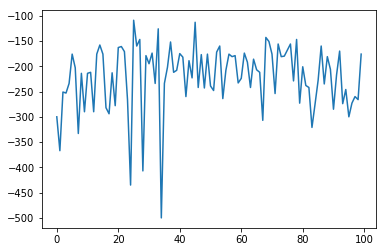

In [14]:
actor_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu,
        'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [100,], 'activation' : tf.nn.relu,
        'learning_rate' : 0.0001}
agent = SACAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)


# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent, train=False) \
        for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

In [15]:
env.close()